In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()


dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC
folder = "/work/work_teamEXOPLANET/KOI_LC/"

time_kepler = np.load(folder+"npy/KOI_LC_time.npy") 
our_process = np.load('/work/work_teamEXOPLANET/KOI_LC/cleaned/LC_kepler_processed.npy')
our_process.shape 

(8054, 71427)

In [2]:
df= pd.read_csv(folder+"csv/kepler_dataset.csv")

df_meta=pd.read_csv('../../KOI_Data/kepler_dataset.csv')
kplr_ids=np.asarray(df['Kepler ID'].values)[[index_fp]]

In [3]:
#### importante:
def prepare_lc(fluxs): #dividir por min
    fluxs = np.asarray(fluxs)
    return fluxs/np.abs(np.nanmin(fluxs))

def extract_nans(fluxs):
    ###extrae los nans y deja tramos de valores continuos
    lc_wind_nan = []
    lengths = []

    sublist = []
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1: ##borrar tramos de largo 1??
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = []
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 
    lc_wind_nan = np.asarray(lc_wind_nan)   
    lengths = np.asarray(lengths)   

    print("Cantidad de tramos: ",len(lengths))
    print("Largo promedio de tramos: ", np.mean(lengths))
    print("Mediana de largo de tramos: ", np.median(lengths))
    print("Min de largo de tramos: ", np.min(lengths))
    print("Max de largo de tramos: ", np.max(lengths))
    return lc_wind_nan

### Version normal

In [23]:
def det_state(a, b, n_sta):
    topes=np.linspace(a, b, n_sta+1)
    estados= []
    ind=1
    for top in topes[:-1]:
        estados.append((top,topes[ind]))
        ind+=1
    return estados

def det_state_2ways(a, b, n_sta_up, n_sta_low):
    estados_up = det_state(a, 0, n_sta_up)
    estados_low = det_state(0, b, n_sta_low)
    return np.concatenate([estados_up,estados_low])

def det_celda(num, estados): 
    for celda, (est_low, est_up) in enumerate(estados):
        if num<est_low and num>=est_up:
            return celda
    return 0 #if sale por arriba (mayor a 1)

def add_transitions(fluxs, transition_m, states):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        transition_m[init_s, fin_s] += 1
    return transition_m

def manual_HMM(wind_fluxs, n_sta_up, n_sta_low=0):
    if n_sta_low == 0: 
        n_sta_low = n_sta_up 
    n_sta = n_sta_up+n_sta_low
    
    transition_m = np.zeros((n_sta,n_sta))
    
    states = det_state_2ways(1,-1, n_sta_up=n_sta_up, n_sta_low=n_sta_low) 
    for fluxs in wind_fluxs:
        add_transitions(fluxs, transition_m, states)
    
    transition_m += 1 #priors
    transition_m = transition_m/transition_m.sum(axis=-1, keepdims=True)        
    return transition_m
                    

## Version paralela (Numba)
para instalar numba: **pip install numba**

In [29]:
from numba import njit, jit
#from numba.typed import List

In [6]:
## no python: njit -- no soporta lista de lista, lista de arrays, si soporta: lista de sets

########### no lo logre hacer funcionar
#@njit(parallel=True, cache=False, fastmath=True)
def extract_nans(fluxs, plot=True):
    ###extrae los nans y deja tramos de valores continuos
    lc_wind_nan = []
    lengths = []

    sublist = [] #para que sepa que el tipo es float
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1: ##borrar tramos de largo 1??
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = [] #para que sepa que el tipo es float
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 

    if plot:
        lengths = np.asarray(lengths)   
        print("Cantidad de tramos: ",len(lengths))
        print("Largo promedio de tramos: ", np.mean(lengths))
        print("Mediana de largo de tramos: ", np.median(lengths))
        print("Min de largo de tramos: ", np.min(lengths))
        print("Max de largo de tramos: ", np.max(lengths))
    return lc_wind_nan

@njit(parallel=True, cache=False, fastmath=True)
def det_state(a, b, n_sta):
    topes=np.linspace(a, b, n_sta+1)
    estados= []
    ind=1
    for top in topes[:-1]:
        estados.append((top,topes[ind]))
        ind+=1
    return estados

@njit(parallel=False, cache=True, fastmath=True)
def det_state_2ways(a, b, n_sta_up, n_sta_low):
    estados_up = det_state(a, 0, n_sta_up)
    estados_low = det_state(0, b, n_sta_low)
    return estados_up + estados_low

@njit(parallel=False, cache=True, fastmath=True)
def det_celda(num, estados): 
    for celda, (est_low, est_up) in enumerate(estados):
        if num<est_low and num>=est_up:
            return celda
    return 0 #if sale por arriba (mayor a 1)

@njit(parallel=False, cache=True, fastmath=True)  #no se pudo paralelizar por el acceso a lista "ind -1"
def add_transitions(fluxs, transition_m, states):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        transition_m[init_s, fin_s] += 1
    return transition_m

@njit(parallel=True, cache=False, fastmath=True)
def manual_HMM(wind_fluxs, n_sta_up, n_sta_low=0):
    if n_sta_low == 0: 
        n_sta_low = n_sta_up 
    n_sta = n_sta_up+n_sta_low
    
    transition_m = np.zeros((n_sta,n_sta))
    
    states = det_state_2ways(1,-1, n_sta_up=n_sta_up, n_sta_low=n_sta_low) 
    for fluxs in wind_fluxs:
        add_transitions(fluxs, transition_m, states)
    
    for i in range(n_sta):
        suma_i = 0
        for j in range(n_sta):
            transition_m[i,j] +=1 #priors
            suma_i += transition_m[i,j]
        transition_m[i] = transition_m[i]/suma_i #normalize
    return transition_m


In [24]:
det_state_2ways(1,-1, n_sta_up=5, n_sta_low=15) #20 estados en total

array([[ 1.        ,  0.8       ],
       [ 0.8       ,  0.6       ],
       [ 0.6       ,  0.4       ],
       [ 0.4       ,  0.2       ],
       [ 0.2       ,  0.        ],
       [ 0.        , -0.06666667],
       [-0.06666667, -0.13333333],
       [-0.13333333, -0.2       ],
       [-0.2       , -0.26666667],
       [-0.26666667, -0.33333333],
       [-0.33333333, -0.4       ],
       [-0.4       , -0.46666667],
       [-0.46666667, -0.53333333],
       [-0.53333333, -0.6       ],
       [-0.6       , -0.66666667],
       [-0.66666667, -0.73333333],
       [-0.73333333, -0.8       ],
       [-0.8       , -0.86666667],
       [-0.86666667, -0.93333333],
       [-0.93333333, -1.        ]])

In [25]:
%%time
fluxs = our_process[1]
fluxs = prepare_lc(fluxs) #divide by min
lc_tramos =  extract_nans(fluxs) #extract nans
#lc_tramos #lista de tramos...
#plt.show(lc_tramos[0])

Cantidad de tramos:  707
Largo promedio de tramos:  77.06506364922207
Mediana de largo de tramos:  72.0
Min de largo de tramos:  2
Max de largo de tramos:  146
CPU times: user 273 ms, sys: 1.12 ms, total: 274 ms
Wall time: 272 ms


### Comportamiento Falsos postiviso

In [26]:
falsos_pos=df.loc[df['NExScI Disposition']=='FALSE POSITIVE']
index_fp=list(falsos_pos.index)
len(index_fp)

our_detrends=our_process[index_fp]
our_detrends.shape

(3976, 71427)

recuperando curva 1
Cantidad de tramos:  707
Largo promedio de tramos:  77.06506364922207
Mediana de largo de tramos:  72.0
Min de largo de tramos:  2
Max de largo de tramos:  146


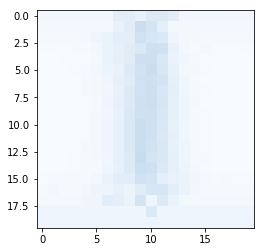

recuperando curva 2
Cantidad de tramos:  803
Largo promedio de tramos:  79.91158156911581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


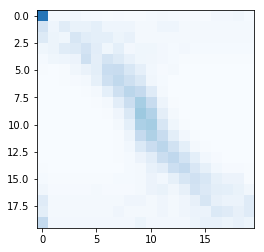

recuperando curva 3
Cantidad de tramos:  788
Largo promedio de tramos:  81.66116751269035
Mediana de largo de tramos:  84.0
Min de largo de tramos:  2
Max de largo de tramos:  146


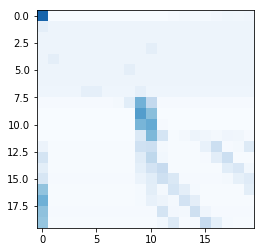

recuperando curva 4
Cantidad de tramos:  806
Largo promedio de tramos:  79.8089330024814
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


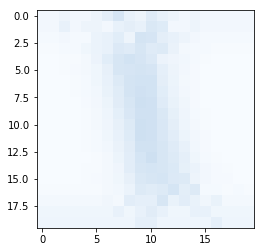

recuperando curva 5
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


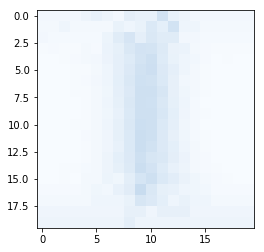

recuperando curva 6
Cantidad de tramos:  772
Largo promedio de tramos:  81.25388601036269
Mediana de largo de tramos:  84.0
Min de largo de tramos:  2
Max de largo de tramos:  146


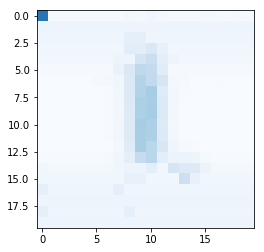

recuperando curva 7
Cantidad de tramos:  801
Largo promedio de tramos:  80.31710362047441
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


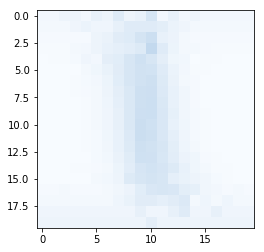

recuperando curva 8
Cantidad de tramos:  467
Largo promedio de tramos:  63.19700214132762
Mediana de largo de tramos:  36.0
Min de largo de tramos:  2
Max de largo de tramos:  145


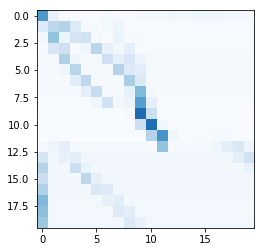

recuperando curva 9
Cantidad de tramos:  254
Largo promedio de tramos:  89.71259842519684
Mediana de largo de tramos:  97.0
Min de largo de tramos:  2
Max de largo de tramos:  146


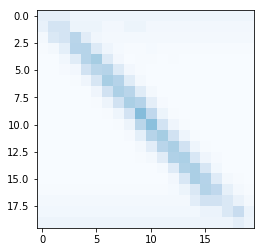

recuperando curva 10
Cantidad de tramos:  807
Largo promedio de tramos:  79.70260223048327
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


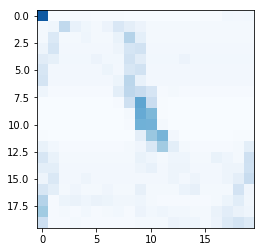

recuperando curva 11
Cantidad de tramos:  107
Largo promedio de tramos:  80.53271028037383
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  145


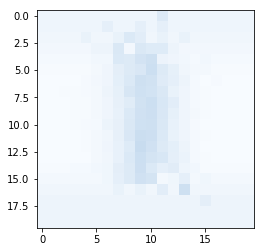

recuperando curva 12
Cantidad de tramos:  654
Largo promedio de tramos:  83.39908256880734
Mediana de largo de tramos:  90.0
Min de largo de tramos:  2
Max de largo de tramos:  149


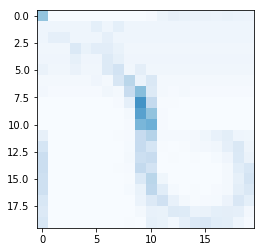

recuperando curva 13
Cantidad de tramos:  929
Largo promedio de tramos:  64.84391819160388
Mediana de largo de tramos:  54.0
Min de largo de tramos:  2
Max de largo de tramos:  146


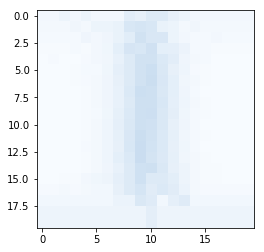

recuperando curva 14
Cantidad de tramos:  812
Largo promedio de tramos:  79.20689655172414
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  146


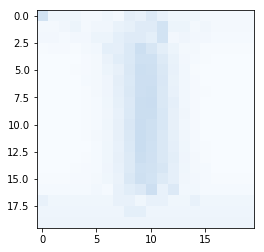

recuperando curva 15
Cantidad de tramos:  836
Largo promedio de tramos:  76.91866028708134
Mediana de largo de tramos:  73.0
Min de largo de tramos:  2
Max de largo de tramos:  146


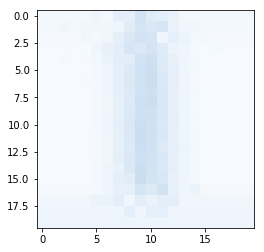

recuperando curva 16
Cantidad de tramos:  393
Largo promedio de tramos:  86.94402035623409
Mediana de largo de tramos:  93.0
Min de largo de tramos:  2
Max de largo de tramos:  149


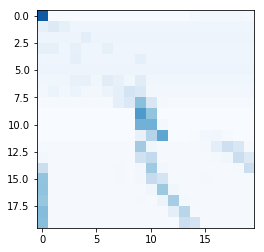

recuperando curva 17
Cantidad de tramos:  828
Largo promedio de tramos:  77.73188405797102
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


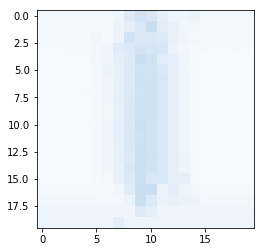

recuperando curva 18
Cantidad de tramos:  831
Largo promedio de tramos:  77.38989169675091
Mediana de largo de tramos:  73.0
Min de largo de tramos:  2
Max de largo de tramos:  149


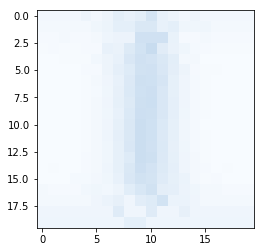

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.81617647058823
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


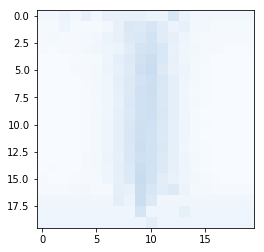

recuperando curva 20
Cantidad de tramos:  777
Largo promedio de tramos:  80.71685971685972
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


KeyboardInterrupt: 

In [28]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    lc_tramos =  extract_nans(fluxs) #extract nans  
    transition_m = manual_HMM(lc_tramos, n_sta_up=10, n_sta_low=10) #si se dejan 5 arriba y 10 abajo cambia harto...

    i+=1
    plt.imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
    plt.show()

### Comportamiento Confirmados

In [11]:
confirmados=df.loc[df['NExScI Disposition']=='CONFIRMED']
index_con=list(confirmados.index)
our_detrends=our_process[index_con]
len(index_con)

2281

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


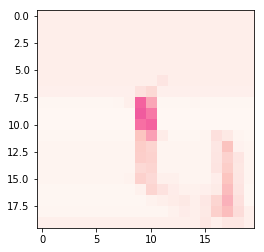

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


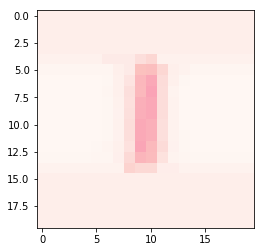

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


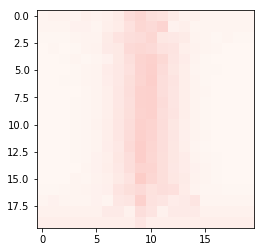

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


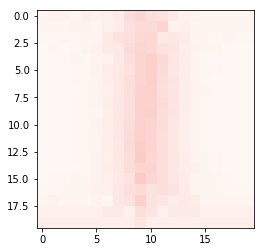

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


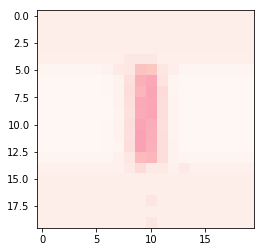

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


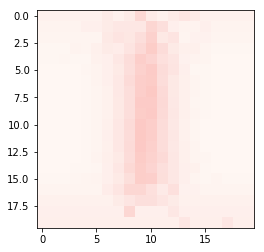

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


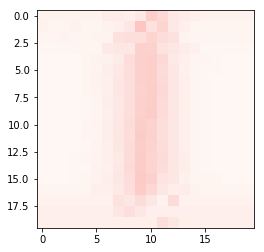

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


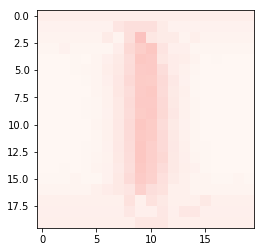

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


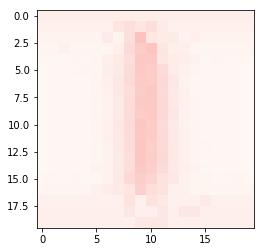

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


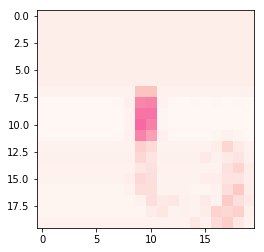

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


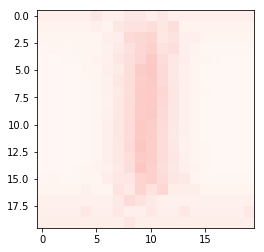

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


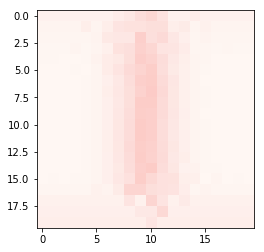

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


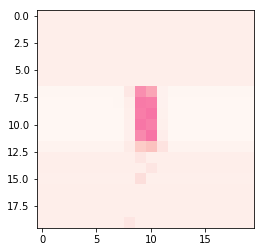

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


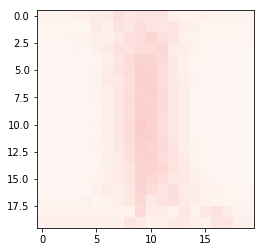

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


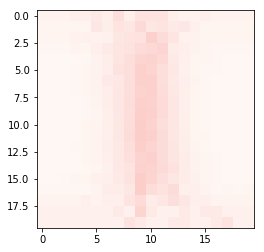

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


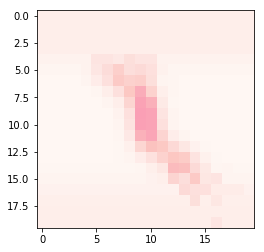

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


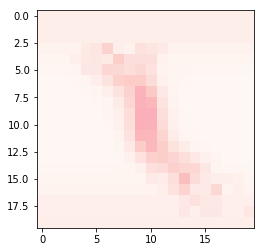

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


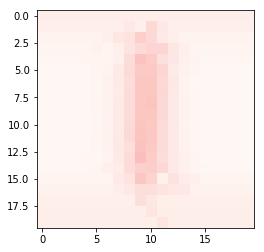

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


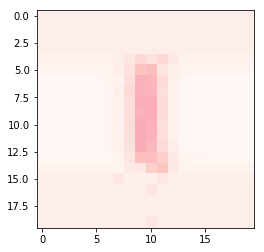

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


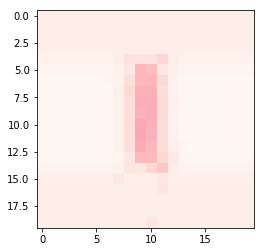

CPU times: user 1min 25s, sys: 6.16 s, total: 1min 31s
Wall time: 7.14 s


In [12]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    lc_tramos =  extract_nans(fluxs) #extract nans
    
    transition_m = manual_HMM(lc_tramos, n_sta_up=10, n_sta_low=10) #si se dejan 5 arriba y 10 abajo cambia harto...

    i+=1
    plt.imshow(transition_m, cmap='RdPu', vmin=0, vmax=1) #el plot se ve raro por esto..
    plt.show()

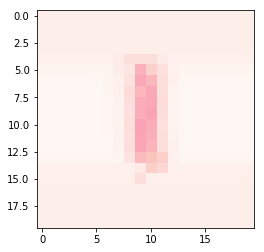

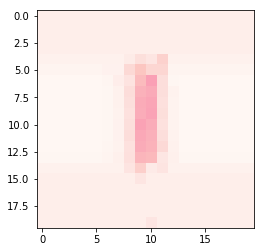

(20, 20)


In [13]:
number = 20

MTF_u10_d10_inv = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u10_d10.npy')  
MTF_u10_d10_noinv = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u10_d10.npy')  
plt.imshow(MTF_u10_d10_noinv[number], cmap='RdPu', vmin=0, vmax=1) 
plt.show()
plt.imshow(MTF_u10_d10_inv[number], cmap='RdPu', vmin=0, vmax=1)
plt.show()

print(MTF_u10_d10_inv[number].shape)

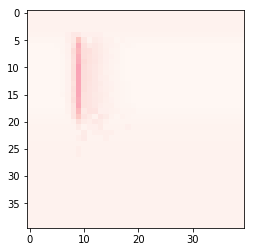

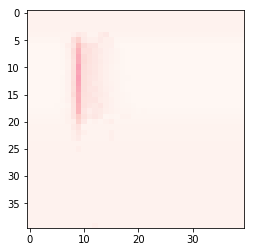

(40, 40)


In [14]:
number = 20

MTF_u10_d10_inv = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u10_d30.npy')  
MTF_u10_d10_noinv = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u10_d30.npy')  
plt.imshow(MTF_u10_d10_noinv[number], cmap='RdPu', vmin=0, vmax=1) 
plt.show()
plt.imshow(MTF_u10_d10_inv[number], cmap='RdPu', vmin=0, vmax=1)
plt.show()

print(MTF_u10_d10_inv[number].shape)

In [15]:
img_nor = MTF_u10_d10_noinv[2]
img_inv = MTF_u10_d10_inv[2]

In [16]:
MTF_u10_d10_inv.shape

(8054, 40, 40)

In [17]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
df_aux

,Kepler ID,KOI Name,Kepler Name,KOI Number,Kepler Disposition,NExScI Disposition,RA (J2000),RA Error,Dec (J2000),Dec Error,...,Contamination Flag,Insolation Flux,Insolation Flux err1,Insolation Flux err2,Fitted Stellar Density,Fitted Stellar Density err1,Fitted Stellar Density err2,Planetary Fit,Disposition Score,File Name
0,757450,K00889.01,Kepler-75 b,889.01,CANDIDATE,CONFIRMED,19 24 33.024,0.0,+36 34 38.57,0.0,...,0,83.21,16.69,-13.87,11.62061,0.20683,-0.40258,LS+MCMC,0.999,kplr000757450-20160128150956_dvt.fits
1,892772,K01009.01,NaN,1009.01,FALSE POSITIVE,FALSE POSITIVE,19 24 36.811,0.0,+36 40 43.83,0.0,...,0,119.70,48.69,-36.91,0.88510,0.10080,-0.39457,LS+MCMC,0.000,kplr000892772-20160128150956_dvt.fits
2,1025986,K07621.01,NaN,7621.01,FALSE POSITIVE,FALSE POSITIVE,19 24 08.086,0.0,+36 46 15.75,0.0,...,0,2.00,0.92,-0.76,33.55994,16.58298,-31.53180,LS+MCMC,0.000,kplr001025986-20160128150956_dvt.fits
3,1026032,K06252.01,NaN,6252.01,FALSE POSITIVE,FALSE POSITIVE,19 24 10.577,0.0,+36 43 45.38,0.0,...,0,98.60,52.46,-21.18,0.73874,0.00021,-0.00735,LS+MCMC,0.000,kplr001026032-20160128150956_dvt.fits
4,1026957,K00958.01,NaN,958.01,CANDIDATE,CANDIDATE,19 25 01.078,0.0,+36 44 37.00,0.0,...,0,13.18,3.00,-1.98,102.86534,5.47239,-30.25813,LS+MCMC,1.000,kplr001026957-20160128150956_dvt.fits
5,1161345,K00984.01,NaN,984.01,CANDIDATE,CANDIDATE,19 24 11.712,0.0,+36 50 23.58,0.0,...,0,186.31,56.73,-28.39,8.16471,4.69586,-1.63188,LS+MCMC,0.711,kplr001161345-20160128150956_dvt.fits
6,1293031,K04162.01,NaN,4162.01,FALSE POSITIVE,FALSE POSITIVE,19 24 05.033,0.0,+36 54 13.13,0.0,...,0,149399.93,35721.31,-106451.43,0.06737,0.00658,-0.00461,LS+MCMC,0.000,kplr001293031-20160128150956_dvt.fits
7,1293046,K07622.01,NaN,7622.01,FALSE POSITIVE,FALSE POSITIVE,19 24 06.372,0.0,+36 54 58.93,0.0,...,0,3.44,0.94,-0.97,34.69388,13.11193,-21.13275,LS+MCMC,0.000,kplr001293046-20160128150956_dvt.fits
8,1431122,K00994.01,NaN,994.01,CANDIDATE,CANDIDATE,19 24 34.198,0.0,+37 03 40.76,0.0,...,0,283.62,100.01,-78.24,0.05666,3.20152,-0.06620,LS+MCMC,0.990,kplr001431122-20160128150956_dvt.fits
9,1432214,K00998.01,NaN,998.01,FALSE POSITIVE,FALSE POSITIVE,19 25 31.846,0.0,+37 04 22.76,0.0,...,0,4.68,2.07,-1.12,17.58377,0.76473,-0.48796,LS+MCMC,0.000,kplr001432214-20160128150956_dvt.fits


In [18]:
labels

array([1, 0, 0, ..., 0, 0, 0])

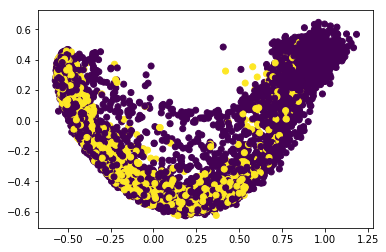

In [19]:
from sklearn.decomposition import PCA
model = PCA(2)
aux = model.fit_transform(MTF_u10_d10_noinv.reshape([MTF_u10_d10_noinv.shape[0],40*40]))

plt.scatter(aux[:,0],aux[:,1], c=labels)

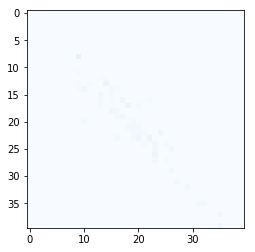

In [20]:
plt.imshow(img_nor-img_inv, cmap='Blues', vmin=0, vmax=1)
#si existen cambios en los pixeles

In [21]:
img_inv.shape

(40, 40)

In [22]:
rgb = np.dstack((img_nor,img_inv))
rgb.shape

(40, 40, 2)

In [23]:
import math
from skimage import io
from skimage import transform
from scipy import fftpack

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal,misc

def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
    kernel_2D *= 1.0 / kernel_2D.max()
    if verbose:
        plt.imshow(kernel_2D, interpolation='none',cmap='jet')
        plt.title("Image")
        plt.show()
    return kernel_2D

#gaussian_kernel(10,sigma = 25,verbose = True)


def gaussian_2fors(size, sigma_x,sigma_y,frequency):
    size = size//frequency + 1
    fil = np.zeros((int(size), int(size)))
    for x_ind,x in enumerate(np.arange(0,size)):
        for y_ind,y in enumerate(np.arange(0,size)):
            fil[x_ind][y_ind] = np.exp(-(((x-size//2)**2)/(2*(sigma_x**2))+((y-size//2)**2)/(2*(sigma_y**2))))
    normalized_fil = fil/np.sum(fil)
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(normalized_fil, extent=[-size//2,size//2,-size//2,size//2],cmap = 'gray')
    return normalized_fil

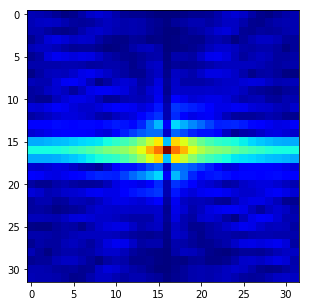

In [24]:
from scipy import fftpack
freq_img=fftpack.fft2(MTF_u10_d10_noinv,(32,32))
#freq_img = np.abs(freq_img)

plt.figure(figsize=(5,5))
plt.imshow(fftpack.fftshift(np.log(1+np.abs(freq_img[20]))),cmap="jet")

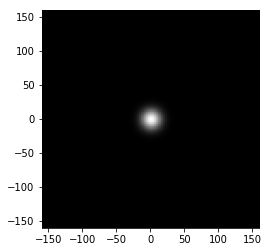

In [25]:
SZ = 32
gauss_fill = gaussian_2fors(SZ,10.0,10.0,0.1)

In [26]:
frequency_gauss_fill = fftpack.fft2(gauss_fill, (32, 32))
frequency_img_conv =  freq_img[20]*frequency_gauss_fill

reverse_frequency_img_conv = fftpack.ifft2(frequency_img_conv)

hs=int(np.floor((SZ/0.5)/2.))
reverse_frequency_img_conv = np.real(reverse_frequency_img_conv)

img_crop = reverse_frequency_img_conv[0:19, 0:19]

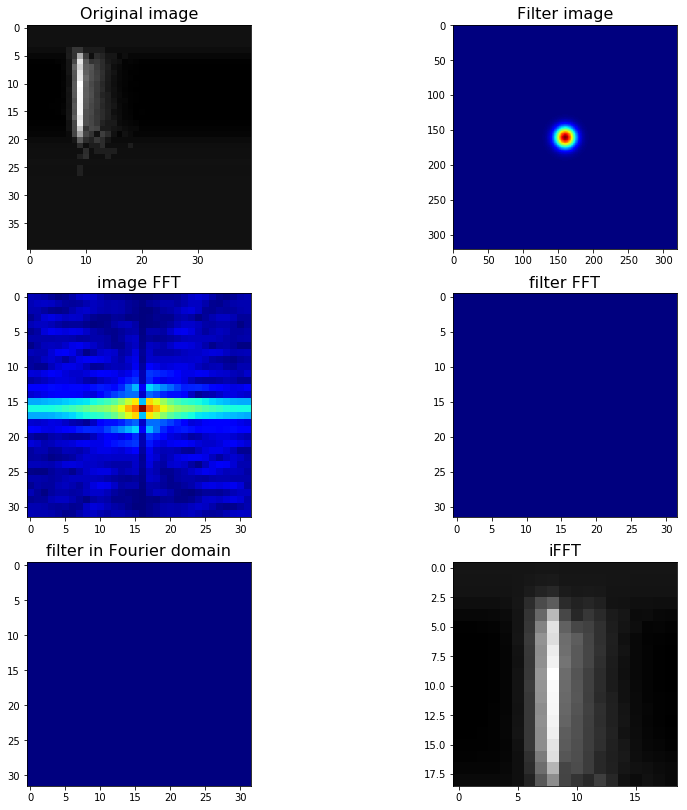

In [27]:
#Check the process
plt.subplot(3,2,1)
plt.imshow(MTF_u10_d10_noinv[20],cmap="gray")
plt.title('Original image', size=16)

plt.subplot(3,2,2)
plt.imshow(gauss_fill,cmap="jet")
plt.title('Filter image', size=16)

plt.subplot(3,2,3)
plt.imshow(fftpack.fftshift(np.log(1+np.abs(freq_img[20]))),cmap="jet")
plt.title('image FFT', size=16)

plt.subplot(3,2,4)
plt.imshow(fftpack.fftshift(np.log(1+np.abs(frequency_gauss_fill))),cmap="jet")
plt.title('filter FFT', size=16)

plt.subplot(3,2,5)
plt.imshow(fftpack.fftshift(np.log(1+np.abs(frequency_img_conv))),cmap="jet")
plt.title('filter in Fourier domain', size=16)

plt.subplot(3,2,6)
plt.imshow(img_crop,cmap="gray")
plt.title('iFFT', size=16)
plt.gcf().set_size_inches((14,14))

In [28]:
MTF_u10_d10_noinv.shape

(8054, 40, 40)

In [29]:
tt =  freq_img*frequency_gauss_fill
tt2 = fftpack.ifft2(tt)
hs=int(np.floor((SZ/0.5)/2.))
tt3 = np.real(tt2)
final_final = []
for i in tt3:
    img_crop = i[hs:20+hs, hs:20+hs]
    final_final.append(img_crop)
final_final = np.asarray(final_final)

In [30]:
final_final.shape

(8054, 0, 0)

In [31]:
#from sklearn.decomposition import PCA
#model = PCA(2)
#aux = model.fit_transform(freq_img.reshape([freq_img.shape[0],64*64]))

#plt.scatter(aux[:,0],aux[:,1], c=labels)

In [32]:
#from sklearn.decomposition import PCA
#model = PCA(2)
#aux = model.fit_transform(final_final.reshape([final_final.shape[0],20*20]))

#plt.scatter(aux[:,0],aux[:,1], c=labels)

# 3er channel

In [6]:
from math import isnan

folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"
#Clean Light Curves
lc_kepler = np.load(folder_lc+"npy/KOI_LC_init.npy")
lc_kepler_times = np.load(folder_lc+'npy/KOI_LC_time.npy')

In [7]:
total_time_list = []
for lc,times in zip(lc_kepler[:5],lc_kepler_times[:5]):
    time_list = []
    aux_t = times[0]
    for i, data in enumerate(lc):
        if not isnan(data):
            time_list.append(times[i] - aux_t)
        else:
            time_list.append(np.nan)
            aux_t = times[i+1]
    total_time_list.append(time_list)

In [8]:
indice = 2
total_time_list[2]

[0.0,
 0.020434699999981376,
 0.04086929999999711,
 0.06130379999999036,
 0.08173850000000016,
 0.10217319999998153,
 0.12260769999997478,
 0.14304229999999052,
 0.1634769999999719,
 0.18391159999998763,
 0.20434609999998088,
 0.2247806999999966,
 0.245215399999978,
 0.26564989999999966,
 0.286084499999987,
 0.30651919999999677,
 0.32695369999999,
 0.34738829999997733,
 0.36782299999998713,
 0.38825759999997445,
 0.4086921999999902,
 0.4291267999999775,
 0.4495613999999932,
 0.46999599999998054,
 0.4904305999999963,
 0.5108650999999895,
 0.5312997999999709,
 0.5517343999999866,
 0.5721688999999799,
 0.5926034999999672,
 0.613038199999977,
 0.6334726999999702,
 0.653907299999986,
 0.6743419999999674,
 0.6947765999999831,
 0.7152111000000048,
 0.7356456999999921,
 0.7560804000000019,
 0.7765148999999951,
 0.7969496000000049,
 0.8173842999999863,
 0.837818800000008,
 0.8582533999999953,
 0.8786879999999826,
 0.8991225999999983,
 0.9195571999999856,
 0.9399918000000014,
 0.9604264999999828

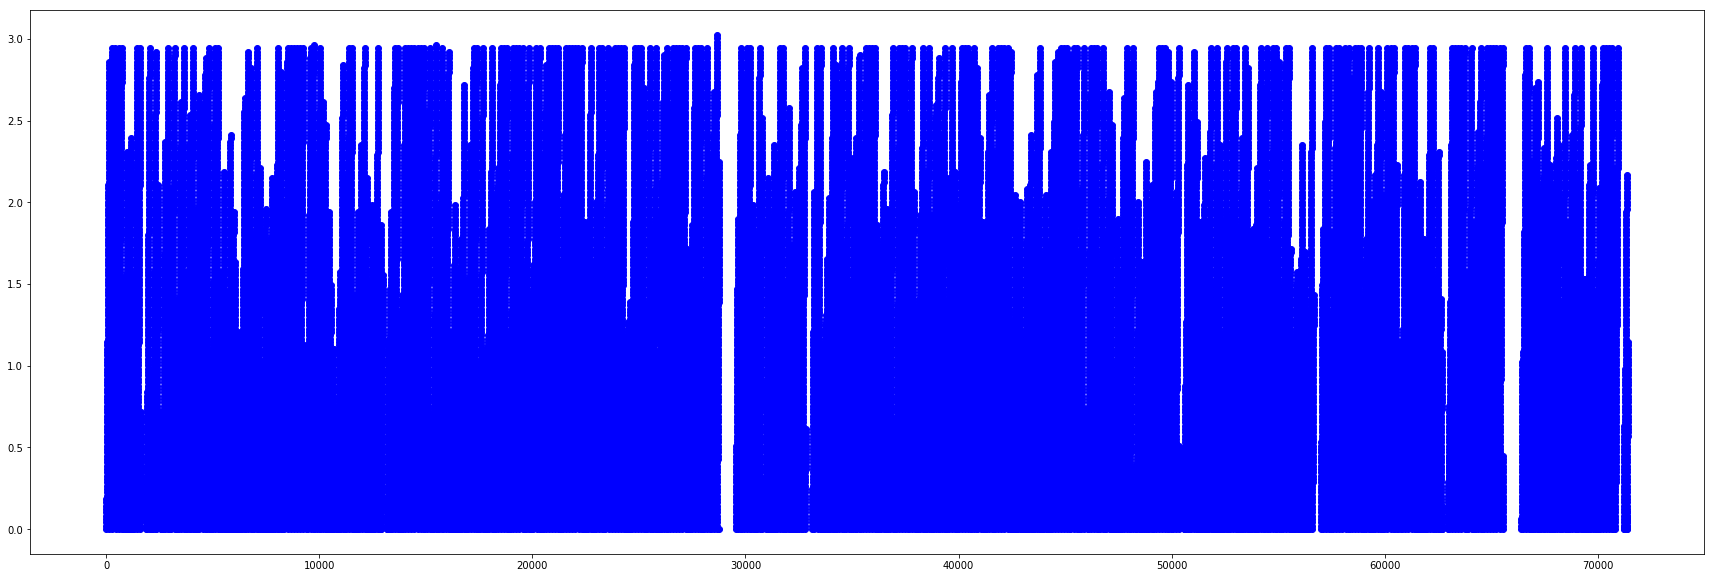

In [9]:
plt.figure(figsize=(30,10))
plt.plot(total_time_list[indice],'bo')
plt.show()

In [33]:
#version gabo
def prepare_lc(fluxs): #dividir por max
    fluxs = np.asarray(fluxs)
    return fluxs/np.abs(np.nanmax(fluxs))


def extract_nans(fluxs):
    ###extrae los nans y deja tramos de valores continuos
    lc_wind_nan = []
    lengths = []

    sublist = []
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1: ##borrar tramos de largo 1??
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = []
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 
    lc_wind_nan = np.asarray(lc_wind_nan)   
    lengths = np.asarray(lengths)   

    print("Cantidad de tramos: ",len(lengths))
    print("Largo promedio de tramos: ", np.mean(lengths))
    print("Mediana de largo de tramos: ", np.median(lengths))
    print("Min de largo de tramos: ", np.min(lengths))
    print("Max de largo de tramos: ", np.max(lengths))
    return lc_wind_nan


def det_state_2ways(n_sta_up):
    estados_up = det_state(0, 1, n_sta_up)
    return np.concatenate([estados_up])

def add_transitions(fluxs, transition_m, states):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        transition_m[init_s, fin_s] += 1
    return transition_m

def manual_HMM(wind_fluxs, n_sta):  
    transition_m = np.zeros((n_sta,n_sta))
    
    states = det_state_2ways(n_sta) 
    for fluxs in wind_fluxs:
        add_transitions(fluxs, transition_m, states)
    transition_m += 1 #priors
    transition_m = transition_m/transition_m.sum(axis=-1, keepdims=True)        
    return transition_m

In [36]:
def extract_nans(fluxs, plot=True):
    ###extrae los nans y deja tramos de valores continuos
    lc_wind_nan = []
    lengths = []

    sublist = [] #para que sepa que el tipo es float
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1: ##borrar tramos de largo 1??
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = [] #para que sepa que el tipo es float
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 

    if plot:
        lengths = np.asarray(lengths)   
        print("Cantidad de tramos: ",len(lengths))
        print("Largo promedio de tramos: ", np.mean(lengths))
        print("Mediana de largo de tramos: ", np.median(lengths))
        print("Min de largo de tramos: ", np.min(lengths))
        print("Max de largo de tramos: ", np.max(lengths))
    return lc_wind_nan

@njit(parallel=True, cache=False, fastmath=True)
def det_state(a, b, n_sta):
    topes=np.linspace(a, b, n_sta+1)
    estados= []
    ind=1
    for top in topes[:-1]:
        estados.append((top,topes[ind]))
        ind+=1
    return estados

@njit(parallel=False, cache=True, fastmath=True)
def det_state_2ways(n_sta):
    estados_up = det_state(0, 1, n_sta)
    return estados_up

@njit(parallel=False, cache=True, fastmath=True)
def det_celda(num, estados): 
    for celda, (est_up) in enumerate(estados):
        if num>=est_up:
            return celda
    return 0 #if sale por arriba (mayor a 1)

@njit(parallel=False, cache=True, fastmath=True)  #no se pudo paralelizar por el acceso a lista "ind -1"
def add_transitions(fluxs, transition_m, states):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        transition_m[init_s, fin_s] += 1
    return transition_m

@njit(parallel=True, cache=False, fastmath=True)
def manual_HMM(wind_fluxs, n_sta):
    transition_m = np.zeros((n_sta,n_sta))
    
    states = det_state_2ways(n_sta) 
    for fluxs in wind_fluxs:
        add_transitions(fluxs, transition_m, states)
    for i in range(n_sta):
        suma_i = 0
        for j in range(n_sta):
            transition_m[i,j] +=1 #priors
            suma_i += transition_m[i,j]
        transition_m[i] = transition_m[i]/suma_i #normalize
    return transition_m


In [44]:
i=0
for lc_our_detrend in total_time_list:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by max
    lc_tramos =  extract_nans(fluxs) #extract nans
    transition_m = manual_HMM(lc_tramos, n_sta = 20) #si se dejan 5 arriba y 10 abajo cambia harto...
    i+=1
    plt.figure(figsize=(10,10))
    plt.imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
    plt.show()

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.83040201005025
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mInvalid use of Function(<built-in function ge>) with argument(s) of type(s): (float64, tuple(float64 x 2))
Known signatures:
 * (bool, bool) -> bool
 * (int8, int8) -> bool
 * (int16, int16) -> bool
 * (int32, int32) -> bool
 * (int64, int64) -> bool
 * (uint8, uint8) -> bool
 * (uint16, uint16) -> bool
 * (uint32, uint32) -> bool
 * (uint64, uint64) -> bool
 * (float32, float32) -> bool
 * (float64, float64) -> bool
 * parameterized
[1mIn definition 0:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 1:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 2:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 3:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 4:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 5:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 6:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 7:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 8:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 9:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 10:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 11:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 12:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 13:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 14:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 15:[0m
[1m    All templates rejected without literals.[0m
[1mThis error is usually caused by passing an argument of a type that is unsupported by the named function.[0m[0m
[0m[1m[1] During: typing of intrinsic-call at <ipython-input-36-9b4277103366> (45)[0m
[1m
File "<ipython-input-36-9b4277103366>", line 45:[0m
[1mdef det_celda(num, estados): 
    <source elided>
    for celda, (est_up) in enumerate(estados):
[1m        if num>=est_up:
[0m        [1m^[0m[0m

[0m[1m[1] During: resolving callee type: type(CPUDispatcher(<function det_celda at 0x7fc0e05807b8>))[0m
[0m[1m[2] During: typing of call at <ipython-input-36-9b4277103366> (52)
[0m
[1m
File "<ipython-input-36-9b4277103366>", line 52:[0m
[1mdef add_transitions(fluxs, transition_m, states):
    <source elided>
    for ind in range(1,len(fluxs)):
[1m        init_s = det_celda(fluxs[ind-1], states)
[0m        [1m^[0m[0m

[0m[1m[1] During: resolving callee type: type(CPUDispatcher(<function add_transitions at 0x7fc3271e89d8>))[0m
[0m[1m[2] During: typing of call at <ipython-input-36-9b4277103366> (63)
[0m
[1m
File "<ipython-input-36-9b4277103366>", line 63:[0m
[1mdef manual_HMM(wind_fluxs, n_sta):
    <source elided>
    for fluxs in wind_fluxs:
[1m        add_transitions(fluxs, transition_m, states)
[0m        [1m^[0m[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new
